# Прогнозирование оттока клиентов фитнес-центра. Кластеризация клиентов

# Оглавление

1. [Этап 1. Загрузка данных и их описание](#step1)   
2. [Этап 2. Исследовательский анализ данных (EDA)](#step2)   
    2.1. [Результаты EDA](#step2-1)    
2. [Прогнозирование оттока клиентов](#step3)   
    2.1. [Результаты моделирования](#step3-1)    
2. [Кластеризация клиентов](#step4)   
    2.1. [Результаты кластеризации](#step4-1)      
5. [Общие выводы и рекомендации](#step5)

<a id="step1"></a>
## Этап 1: загрузка и описание данных


Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

__'Churn'__ — факт оттока в текущем месяце (целевая переменная);

#### Текущие поля в датасете:
Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);- 
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [15]:
#общий импорт для аналитических целей
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#импорт для моделирования
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#импорт для кластеризации
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [16]:
#функция для массового вывода подсчета количества значений, удобно для бинарных осмотра категориальных переменных
def CountValues(df, Columns):
    for Column in Columns:
        print (Column)
        print (df[Column].value_counts(dropna=False))
        print ('=======================================')   
        
#функция для вывода нужных в проекте метрик
def print_all_metrics(y_true, y_pred, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

#функция отрисовки кластеров на графике
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(df[x_name], df[y_name],
           hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
    
def describe_col(data, desc_by, col_list, metrics_list=['mean', 'std']):
    '''Выводит описательные метрики в разрезе по категориальному признаку по списку колонок

    data - датафрейм 
    desc_by - в каком разрезе выводить признаки, аналогично columns в pivot_table
    col_list - список колонок, пойдут в индекс строк первого порядка
    metrics_list - список метрик, поддерживаемых методом describe(), пойдут в индекс строк второго порядка. '''
    curr_option = pd.options.display.max_rows
    pd.set_option('display.max_rows',None)
    temp_df = data.groupby(desc_by)[col_list].describe().T
    print(temp_df[temp_df.index.isin(metrics_list, level=1)])
    pd.set_option('display.max_rows',curr_option)

In [17]:
local_path = 'datasets/gym_churn.csv'
cloud_path = '/' + local_path

In [18]:
try:
    data = pd.read_csv(local_path, nrows=5)
except:
    data = pd.read_csv(cloud_path, nrows=5)
data    

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Данные загрузились нормально, можно загружать полностью:

In [19]:
try:
    data = pd.read_csv(local_path)
except:
    data = pd.read_csv(cloud_path)

## Этап 2: исследовательский анализ данных<a id="step2"></a>

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Что можно отметить в первом приближении:
- пропуски в данных в смысле отсутствуют. Есть некоторый риск, что представлены нулями, но проверить мы не можем;
- бинарные признаки True|false переменные представлены целочисленным форматом;
- некоторые названия содержат прописные буквы. Произведем замену для удобства.

In [21]:
data.columns = map(str.lower, data.columns)
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Создадим списки полей для различной обработки, а также срезы датасета по целевой переменной:

In [22]:
binary_col = ['gender', 'near_location', 'partner', 'promo_friends', 'phone' , 'churn']
num_col = data.columns[~data.columns.isin(binary_col)]
data_stay = data[data.churn == 0]
data_churn = data[data.churn == 1]

Посмотрим на характеристики датасета в целом, а также в разрезе по целевой переменной.

In [23]:
CountValues(data, binary_col)

gender
1    2041
0    1959
Name: gender, dtype: int64
near_location
1    3381
0     619
Name: near_location, dtype: int64
partner
0    2053
1    1947
Name: partner, dtype: int64
promo_friends
0    2766
1    1234
Name: promo_friends, dtype: int64
phone
1    3614
0     386
Name: phone, dtype: int64
churn
0    2939
1    1061
Name: churn, dtype: int64


Посетителей разных полов почти одинаковое количество, большинство из них ходят в зал рядом с домом, почти половина имеет корпоративную карту, треть пришли по акции "приведи друга". Почти все оставили контактный номер телефона.
Отток за месяц составил около 25%.

In [24]:
data[num_col].describe()

,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


Средний срок абонемента - 4,5 месяца, с высоким стандартным отклонением: у половины пользователей абонемент всего на месяц.

Центр привлекает молодую аудиторию: средний возраст 29 лет с небольшим стандартным отклонением вокруг, 25 и 75 процентили находятся внутри стандартного отклонения. Наибольший возраст посетителя - всего 41 год. 

В среднем уровень "опыта" посетителя небольшой - 4 месяца с момента первого посещения. 75 процентиль ненамного больше - всего 5 месяцев.

Частота посещений в целом и за месяц - в среднем чуть меньше 2 раз, со стандартным отклонением в единицу. Мало кто ходит больше 3 раз в неделю.


__Посмотрим на категориальные данные в разрезе по оттоку:__

In [25]:
for df in [data_stay, data_churn]:
    CountValues(df, binary_col)
    print('================================================================')

gender
1    1499
0    1440
Name: gender, dtype: int64
near_location
1    2566
0     373
Name: near_location, dtype: int64
partner
1    1570
0    1369
Name: partner, dtype: int64
promo_friends
0    1900
1    1039
Name: promo_friends, dtype: int64
phone
1    2656
0     283
Name: phone, dtype: int64
churn
0    2939
Name: churn, dtype: int64
gender
1    542
0    519
Name: gender, dtype: int64
near_location
1    815
0    246
Name: near_location, dtype: int64
partner
0    684
1    377
Name: partner, dtype: int64
promo_friends
0    866
1    195
Name: promo_friends, dtype: int64
phone
1    958
0    103
Name: phone, dtype: int64
churn
1    1061
Name: churn, dtype: int64


Можно заметить, что:
- те, кто прекращают посещения, заметно чаще живут/работают не рядом со спортазлом;
- реже являются участниками программы "приведи друга";
- значительно реже являются корпоративными клиентами.

Посмотрим на числовые переменные в разрере по оттоку:

In [26]:
describe_col(data, 'churn', num_col, ['mean', 'std', 'max'])

churn                                            0           1
contract_period                   mean    5.747193    1.728558
                                  std     4.716942    2.132371
                                  max    12.000000   12.000000
group_visits                      mean    0.464103    0.268615
                                  std     0.498795    0.443448
                                  max     1.000000    1.000000
age                               mean   29.976523   26.989632
                                  std     3.009933    2.895163
                                  max    41.000000   38.000000
avg_additional_charges_total      mean  158.445715  115.082899
                                  std    99.801599   77.696419
                                  max   552.590740  425.535220
month_to_end_contract             mean    5.283089    1.662582
                                  std     4.363522    1.964593
                                  max    12.000000   12

Посмотрим распределения по этим признакам:

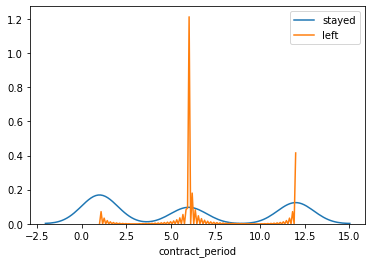

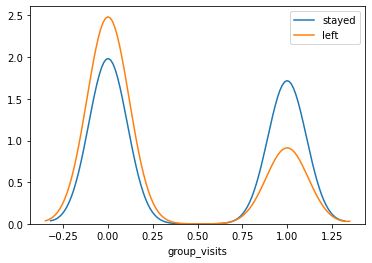

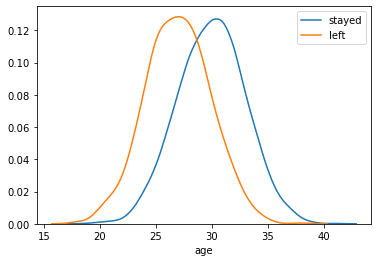

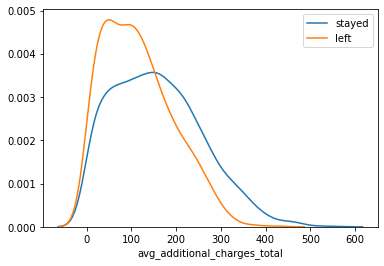

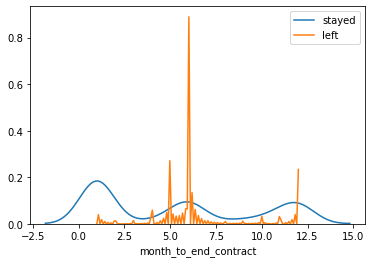

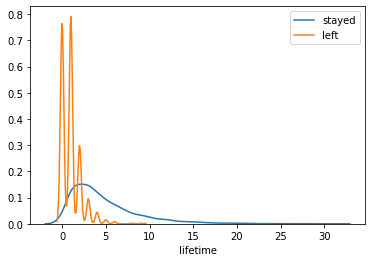

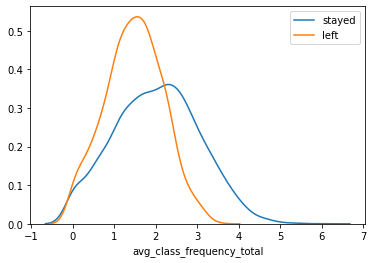

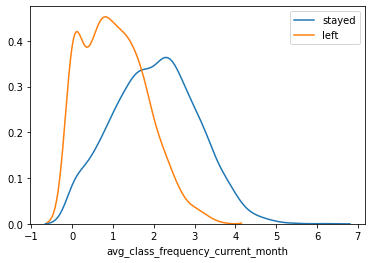

In [27]:
for metric in num_col:
    sns.distplot(data[data.churn==False][metric], hist=False, label='stayed')
    sns.distplot(data[data.churn==True][metric], hist=False, label ='left')
    plt.show()

Действительно, распределения по этим признакам заметно различаются, особенно это касается признаков по опыту посещения спортзала, частоте посещения в последний месяц, и времени до истечения контракта с залом.

Для бинарных признаков гистограммы подходят плохо, поэтому построим столбчатые диаграммы.
Для наглядности поступим немного необычно и сгрупируем вместе метрики внутри каждой категории (ушли и остались).

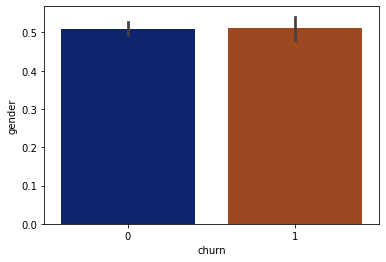

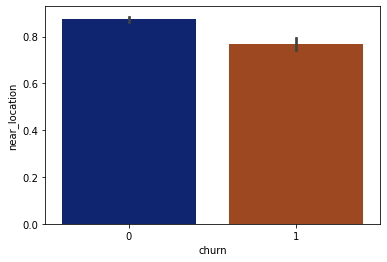

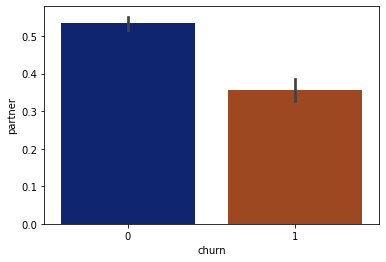

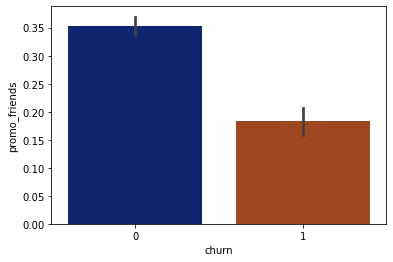

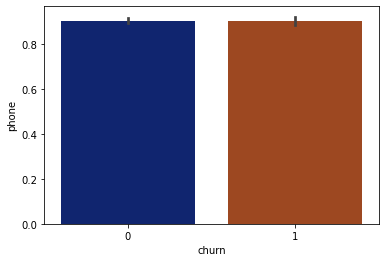

In [28]:
for metric in binary_col:
    if metric == 'churn':
        pass
    else:
        sns.barplot('churn', metric, data = data, palette= 'dark')
        plt.show()

Наиболее заметные разницы в распределении признака здесь - в участии в программе "приведи друга", в признаке корпоративной карты, и в отдалении спортзала от места жительства/работы. 

Построим матрицу корреляций и подсветим показатели с помощью тепловой карты, чтобы было легче интерпретировать результаты:

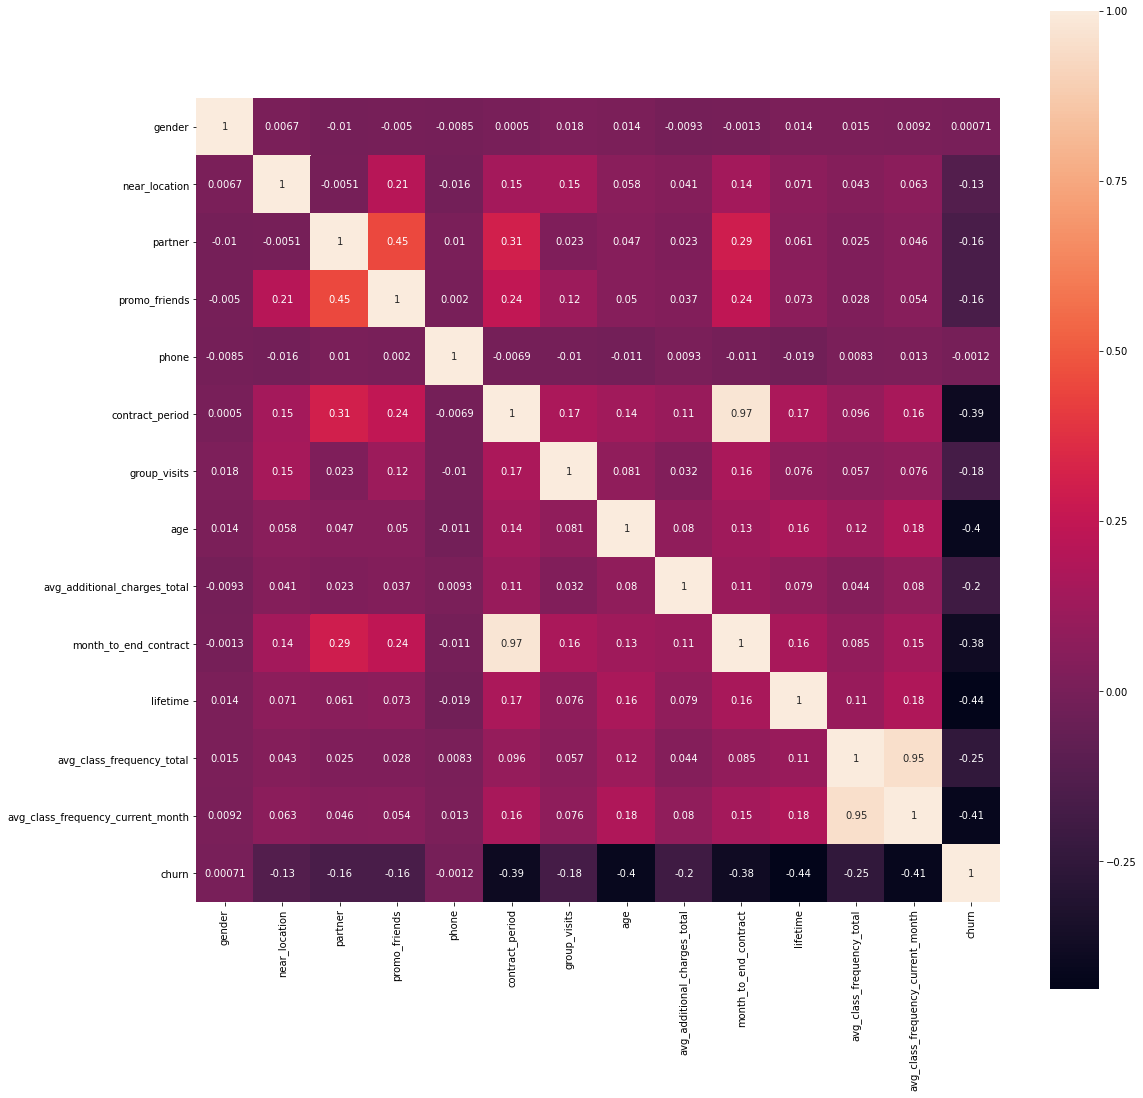

In [29]:
cm = data.corr()
fig, ax = plt.subplots(figsize = (18,18))

sns.heatmap(cm, annot=True, square = True)
plt.show()

Здесь можно увидеть следующее:
- длительность контракта вполне ожидаемо коррелирует с оставшимся сроком контракта на уровне, близком к единице.
- частота посещений в целом коррелирует с частотой посещения вообще. По всей видимости, это связано с тем, что многие бросают уже после первого или второго месяца занятий, и паттерн поведения не успевает измениться. Если у "опытных посетителей" и происходит какое-то существенное изменение в поведении перед тем, как они бросают занятия, то по этому датасету мы это не выявим, судя по всему.

Чтобы избежать мультиколлинеарности, от дублирующих признаков следует избавиться.
По поводу частоты посещений:
- с одной стороны, можно оставить общую частоту посещений, потому что она содержит больше информации и таким образом более устойчива и надежна.
- с другой стороны, мы предсказываем конкретную величину - вероятность перестать посещать зал в следующем месяце. Для этих целей оперативная статистика именно за последний месяц кажется более логичным предиктором. Для новичков эти показатели не будут различаться, а вот если старый лояльный пользователь вдруг начнет реже посещать, модель это увидит по метрике последнего месяца. 

Вторая причина мне кажется более веской, так  что оставим статистику за последний месяц.

По поводу периода до конца контракта:
- есть следующее соображение: сильная корреляция обсуловлена прежде всего тем, что многие имеют абонемент на месяц, который через месяц заканчивается. Если мы строим предиктивную модель и кластеризуем пользователей с целью вывести индивидуальные стратегии удержания, то информация о том, когда заканчивается абонемент, кажется более полезной и, опять же, более актуальной во времени для предсказания поведения в следующем месяце. Информация о сроке заключения контракта по факту содержит в себе только очевидные стратегии "стимулировать покупать более длительные абонементы" и информацию "те, кто покупает абонемент на месяц, более склонны покидать зал без продления", которая находит симметричное отражение во второй метрике. 

Поэтому я бы оставил информацию об оставшемся числе месяцев. 


In [30]:
data.drop(columns = ['contract_period', 'avg_class_frequency_total'], inplace=True)

### Общие выводы по этапу <a id="step2-1"></a>

1. Мы изучили описательные статистики по данным, в том числе в разрезе по целевой переменной (прекращение посещений)
2. Обнаружили заметные различия в признаках между группами в разрезе по целевой переменной, а именно можем сформулировать следюущие гипотезы:

    отдаленность спортзала от места жительства/работы повышает вероятность потери клиента, участие в программе "приведи друга" и корпоративный статус карты - увеличивает вероятность клиента остаться. Также, чем меньше времени клиент посещает спортзал и чем меньше осталось времени до истечения контракта, тем больше шансов, что он перестанет посещать. Также уход клиента могут предсказывать низкая частота посещений зала в целом и групповых занятий в частности и низкие расходы на дополнительные услуги.
    
    
3. Мы изучили признаки на мультиколлинеарность и избавились от двух характеристик, которые коррелировали с другими признаками на уровне коэффициента детерминации 0.95-0.97. 

## Этап 3: прогнозирование оттока клиентов
<a id="step3"></a>

Определим целевую переменную и признаки, разделим выборку на обучающую и валидационную, и стандартизируем данные:

In [31]:
X = data.drop('churn', axis = 1)
y = data['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Зададим модели логистической регрессии и случайного леса, обучим их и выведем метрики:

In [32]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state = 0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
#lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# выведем все метрики
print_all_metrics(y_test, lr_predictions, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.84
	F1: 0.84


C:\Users\ChernenkovDO\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
for i in range(0, len(X.columns)):
    print('коэффициент признака {} равен {}'.format(X.columns[i], round(lr_model.coef_.item(i),3)))


коэффициент признака gender равен 0.021
коэффициент признака near_location равен -0.066
коэффициент признака partner равен -0.068
коэффициент признака promo_friends равен -0.141
коэффициент признака phone равен -0.075
коэффициент признака group_visits равен -0.378
коэффициент признака age равен -1.165
коэффициент признака avg_additional_charges_total равен -0.567
коэффициент признака month_to_end_contract равен -1.367
коэффициент признака lifetime равен -3.555
коэффициент признака avg_class_frequency_current_month равен -1.281


Поскольку мы использовали стандартизированные признаки, коэффициенты при них вполне можно изучать аналитически. Так, можно отметить, что наибольшей предсказательной силой в модели обладают, как и предполагали, **опыт посещения зала, частота посещения в последний месяц, число месяцев до окончания контракта, а также, в меньшей степени, посещение групповых занятий, оплата дополнительных услуг и участие в программе приведи друга**.

Из неожиданного: сила влияния **ближайшего расположения** оказалось слабой, как и **партнерской программы**, но почему-то модель указывает еще на **важность возраста**. Я в силу профессиональной деформации могу придумать рациональное объяснение любому результату, но на мой взгляд данный параметр является наиболее слабо интерпретируемым из всех признаков.

In [34]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) # Ваш код здесь
#rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]  # Ваш код здесь
# выведем все метрики
print_all_metrics(y_test, rf_predictions,  title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.80
	F1: 0.82


In [35]:
for i in range(0, len(X.columns)):
    print('важность параметра {} равна {}'.format(X.columns[i], round(rf_model.feature_importances_[i],3)))

важность параметра gender равна 0.016
важность параметра near_location равна 0.012
важность параметра partner равна 0.016
важность параметра promo_friends равна 0.014
важность параметра phone равна 0.008
важность параметра group_visits равна 0.021
важность параметра age равна 0.147
важность параметра avg_additional_charges_total равна 0.123
важность параметра month_to_end_contract равна 0.119
важность параметра lifetime равна 0.315
важность параметра avg_class_frequency_current_month равна 0.209


<a id="step3-1"></a>
### Результаты моделирования
Метрика Accuracy в данном случае не очень информативна: по данным выборки, уходит четверть посетителей, т.е. не соблюдается баланса классов классификации. 
По precision и Recall модели симметричны: с точным предсказанием разных классов лучше справляется лес, а с выявлением целевой метрики - логистическая регрессия. С формальной точки зрения логистическая регрессия чуть лучше (F1 чуть выше). 

Более подробно мы коснемся вопроса в общем выводе, но в целом можно сказать, что обе модели вполне функциональны, но поскольку мы сосредоточены в первую очередь на поиске клиентов, которых есть риск потерять, можно отдать предпочтение логистической регрессии как модели, которая лучше таких клиентов определяет (максимизирует метрику Recall). 

<a id="step4"></a>
## Этап 4: кластеризация клиентов


Проведем стандартизацию всего массива признаков и построим дендрограмму:

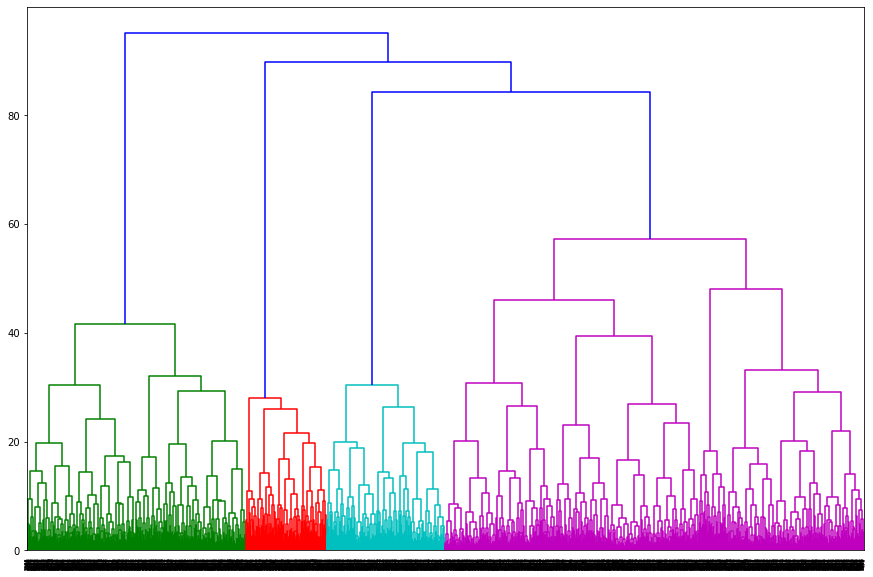

In [36]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

На дендрограмме выделяется **четыре различных кластера**, можно было бы взять четыре за основу, но для собюдения условий задания берем 5.

In [37]:
km = KMeans(n_clusters = 5, random_state=0 )
labels = km.fit_predict(X_sc )
 
# сохраняем метки кластера в поле датасета
X['cluster'] = labels
X.groupby(['cluster']).mean()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month
cluster,,,,,,,,,,,
0,0.492000,0.994000,0.953000,1.000000,0.906000,0.528000,29.633000,154.086252,6.730000,4.287000,1.919105
1,0.495352,0.998672,0.378486,0.046481,0.903054,0.000000,30.342629,174.392898,4.698539,5.166003,2.237272
2,0.510507,1.000000,0.224969,0.114957,0.899876,0.187886,26.800989,111.061687,1.710754,1.422744,0.984420
3,0.502455,0.000000,0.489362,0.072013,0.913257,0.232406,28.700491,137.375245,2.826514,3.027823,1.599583
4,0.551391,0.998791,0.275695,0.074970,0.897219,1.000000,30.275695,155.484435,4.730351,4.499395,2.044372


Второй кластер выглядит как "отточный": в нем все переменные, которые мы отмечали как предиктивные, обладают наименьшими средними значениями.  Кластеры 1 и 4 похожи на наиболее усточивые - более старшие посетители, с большим опытом посещения зала, с повышенными расходами на сопутствующие услуги. Кластеры 0 и 3 представляют собой промужуточные варианты, третий более близок к "отточному".


Оставим ключевые, в нашем понимании, числовые характеристики, чтобы не утонить в графиках, и построим pairlot:

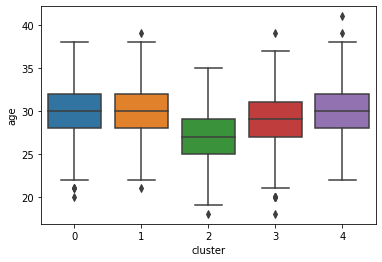

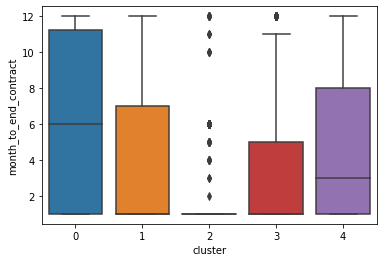

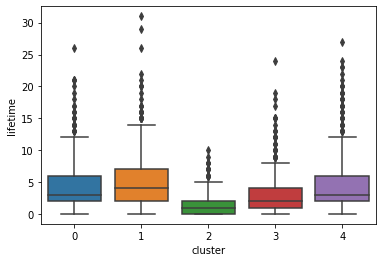

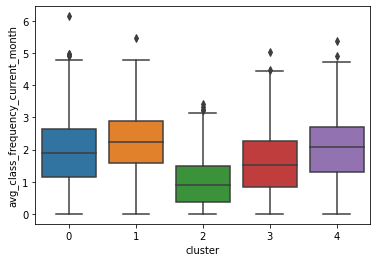

In [38]:
for metric in [ 'age', 'month_to_end_contract', 'lifetime','avg_class_frequency_current_month']:
    sns.boxplot(x='cluster', y = metric, data=X)
    plt.show()

По графикам заметно, что второй кластер представляет собой наиболее подтвержденный риску оттока. Особенно интересно то, что возраст действительно заметно влияет: в 2 кластере посетители в среднем прилично моложе (при условии, что в целом разброс показателя возраста посетителей был не самый большой).
Также, судя по всему, 1 кластер является наиболее "надежным", в большей степени, чем 0: в нем сгруппированы более старшие, более опытные посетители, которые больше тратят и чаще всех посещают зал.

Для бинарных признаков построим агрегирующий barplot в разрере по кластерам:

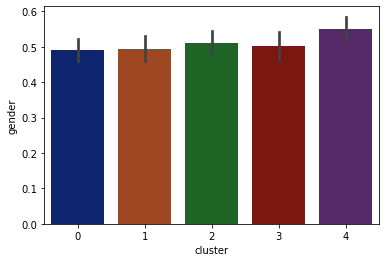

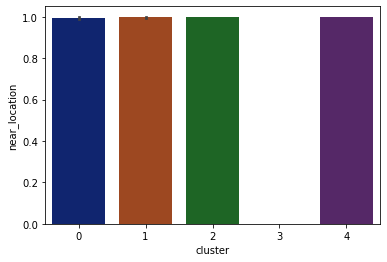

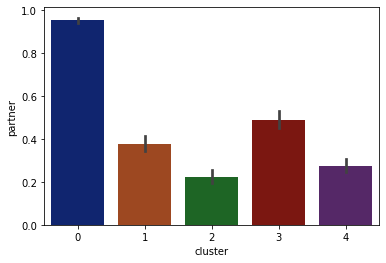

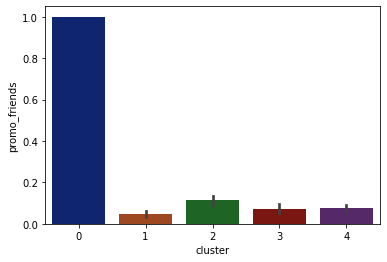

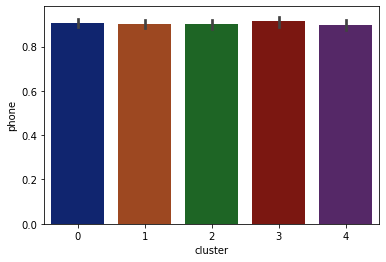

In [39]:
for metric in ['gender', 'near_location', 'partner', 'promo_friends', 'phone']:
        sns.barplot('cluster', metric, data = X, palette= 'dark')
        plt.show()

### По столбчатой диаграмме заметно следующее:
- внутри кластеров пол посетителей распределен равномерно;
-  всех пользователей, живущих/работающих далеко от зала, алгоритм выделил в 3 кластер;
- в 2ый "отточный" кластере большинство клиентов не корпоративные, а вот в нулевой попало большинство корпоративных клиентов;
- также почти все участники программы "приведи друга" попали в кластер 0. 
- в отношении наличия данных по телефону алгоритм распределил пользователей равномерно. Это хорошая новость: значит, этот не самый интерпретируемый и полезный для анализа фактор не особенно повлиял на кластеризацию (тем не менее, возможно в любом случае было бы лучше без него).

In [40]:
data_clustered = X.merge(y, left_index=True, right_index=True)

In [41]:
clusters = pd.DataFrame(data_clustered.groupby('cluster').agg({'churn' :'sum', 'gender': 'count'}).reset_index())
clusters.rename(columns={'gender':'customers'}, inplace=True)
clusters['churn_percent'] = clusters.churn / clusters.churn.sum()
clusters.style.format({'churn_percent':'{:.2%}'})

,cluster,churn,customers,churn_percent
0,0,108,1000,10.18%
1,1,35,753,3.30%
2,2,599,809,56.46%
3,3,245,611,23.09%
4,4,74,827,6.97%


Да, выводы, которые мы сделали по графикам, подтверждаются: 2 кластер - "отточный", на него приходится 56% всего оттока, 3ий кластер рискованный, 23%, 0и 4 условно устойчивые,  10% и 7% соответственно, и 1 - надежный, всего 3%. 

### Выводы по кластеризации  
<a id="step4-1"></a>
На основании дендрограммы мы определили, что оптимальным числом кластеров является 4, но использовали 5, чтобы соответствовать условиям задания.

Мы изучили графики распределения числовых и бинарных признаков, заметили существенные различия между кластерами по большинству переменных: возрасту, частоте посещения, дополнительным расходам, участию в акции "приведи друга" и типу карты (корпоративная или нет). Также на кластеризацию могли искуственным образом повлиять такие признаки, как телефон и удаленность от зала, которые по данным нашего предиктивного анализа не имеют большой предсказательной силы. Возможно, без них и при разбиении на 4 кластера мы бы получили немного другие результаты.

Но в целом кластеризация вполне достойная: мы выделили в единый кластер наиболее рискованных клиентов (56% оттока), в отдельный наиболее надежных (3% оттока), а также несколько промежуточных (7%, 10% и 23%). Скорее всего, именно между ними мы бы наблюдали наибольшие изменения, если бы меняли используемые признаки и/или число кластеров.

## Этап 5: Общие выводы и рекомендации
<a id="step5"></a>

Результаты исследования в целом подтверждает то, что мы знаем о выработке устойчивых паттернов поведения:
- Чем дольше человек занимается, тем меньше вероятность, что он бросит;
- Социальный компонент помогает: если человек занимается вместе с другом, поведение будет более устойчивым;
- Если услуга обходится дешевле (как карта по корпоративному тарифу) - больше шансов, что человек продолжит ей пользоваться на регулярной основе;
- Чем чаще практикуется человек, тем быстрее это входит в привычку и становится частью привычного поведения и элементом идентичности. 

С учетом нашего анализа можно предложить следующие направления работы:

1. Объединить работающие стимулы со стимулирующими. Например, предлагать прогрессирующие скидки по акции "приведи друга" в зависимости от срока абонемента, и в целом стимулировать к покупке более долгих абонементов. Акция хорошо работает, и при этом оба фактора работают на удержание.
2. Продумать программу увеличения частоты посещения спортзала. Это могут быть предложения по схеме "посетите спортзал трижды в неделю и выиграйте бесплатное занятие с тренером" (переменные награды отлично стимулируют дофамин), "гарантируем скидку за 12 посещений в месяц" и т.д. Достаточно частое обращение к привычке (посещение спортзала) способствует выработке новой идентичности.
3. Адресно работать посетителями, попадающими в "отточный" кластер - молодых начинающих спортсменов. Следует проанализировать, какие расходы  можно себе позволить на удержание посетителя, и попробовать протестировать разные индивидуальные стратегии - напоминания, скидки, подарить занятия с тренером, но которое можно реализовать только в следующем месяце, и т.д.
4. Судя по всему, партнерские корпоративные карты хорошо работают. Стоит продолжать ориентировать часть маркетинговых расходов на привлечение посетителей через их работодателей. Многие современные исследования говорят о положительном влиянии спорта на когнитивные способности и снижение стресса, так что работодателю современного типа вполне можно продать подобное партнерство.